<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP03_Last_Blocks_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%; border:none; background:none;">
  <tr style="border:none;">
    <td style="border:none; vertical-align:middle; text-align:left; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0"><img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="100px" style="border-radius: 4px;"></a>
    </td>
    <td style="border:none; vertical-align:middle; text-align:left;">
      <p style="margin: 0; font-size: 14px;">
        Supplementary code for the <a href="https://hubs.la/Q040tvsK0">Rearchitecting LLMs</a> book by <a href="https://github.com/peremartra">Pere Martra</a>.<br>
        <br>
        <strong>MEAP Special:</strong> Get it at 50% off with code <strong>MLMartra</strong> (valid until Feb 26th).<br>
        <br>
        Code repository: <a href="https://github.com/peremartra/Rearchitecting-LLMs">https://github.com/peremartra/Rearchitecting-LLMs</a>
      </p>
    </td>
  </tr>
</table>

# **Rearchitecting LLMs**
## **Chapter 6: Experiments**
### Removing 4 last Transformer Blocks

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

## Section 0: Environment & Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted - you can sleep now!")

Mounted at /content/drive
✓ Drive mounted - you can sleep now!


In [2]:
#Samples in the training dataset.
RECOVERY_SAMPLES = 2000
# Flag to skip benchmarks during development (set to True for final run)

EPOCHS=5
LEARNING_RATE=2e-5  #1e-5

# Define benchmark tasks
RUN_FULL_BENCHMARKS = True
BENCHMARK_LIMIT = 500  #From 100 for quick testing to None for full evaluation
BENCHMARK_TASKS = [
      "arc_easy",
      "winogrande",
      "hellaswag",
      "lambada_openai",
      "piqa"
]


In [3]:
# Install required packages
!pip install -q transformers accelerate datasets
!pip install -q optipfair  # For creating pruned model on-the-fly
!pip install -q matplotlib seaborn tqdm
!pip install -q lm_eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.7/358.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [5]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [6]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
    evaluate_metrics,  # Loss & Perplexity
    clear_gpu_cache
)

✅ utils.py downloaded successfully


## Section 1: Load Models and Create Pruned Student

In [ ]:
MODEL_NAME = "google/gemma-3-270m"

print(f"Loading Teacher model: {MODEL_NAME}")
teacher_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# Freeze teacher (we never update it)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Print architecture info
n_teacher_layers = len(teacher_model.model.layers)
hidden_dim = teacher_model.config.hidden_size

print(f"\n{'='*60}")
print(f"Teacher Model: {MODEL_NAME}")
print(f"{'='*60}")
print(f"Total layers: {n_teacher_layers}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Total parameters: {teacher_model.num_parameters():,}")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1e9:.2f} GB")
print(f"{'='*60}\n")

## Section 2: Prepare Training Dataset

In [8]:
# Load SlimPajama dataset in streaming mode for efficiency
#print("Loading SlimPajama-627B dataset...")
#dataset = load_dataset(
#    "cerebras/SlimPajama-627B",
#    split="train",
#    streaming=True
#)

# Take a representative subset for our recovery process
#
#print(f"Selecting {RECOVERY_SAMPLES:,} samples for knowledge recovery...")

# Use streaming dataset's take method
#distillation_dataset = dataset.take(RECOVERY_SAMPLES)
#print(f"✓ Streaming dataset ready: {RECOVERY_SAMPLES:,} samples")

In [ ]:
# ==============================================================================
# Section 2: Prepare Training Dataset (COMPLETE VERSION)
# ==============================================================================

from datasets import load_dataset, Dataset
from tqdm.auto import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Define tokenization parameters
MAX_LENGTH = 512

def tokenize_function(examples):
    """Tokenize text samples for training"""
    texts = examples['text'] if isinstance(examples, dict) else examples
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

print(f"✓ Tokenization function ready (max_length={MAX_LENGTH})")

# Load Cosmopedia dataset
print("\nLoading Cosmopedia dataset...")
dataset_name = "HuggingFaceTB/cosmopedia"
subsets = ["stories", "wikihow", "openstax", "web_samples_v1"]
samples_per_subset = int(RECOVERY_SAMPLES / 4)
num_samples = samples_per_subset * len(subsets)

print(f"Loading {len(subsets)} subsets with {samples_per_subset:,} samples each...")

all_samples = []
for subset in subsets:
    print(f"  Loading {subset}...")
    subset_data = load_dataset(dataset_name, subset, split="train", streaming=True)
    subset_samples = list(subset_data.take(samples_per_subset))
    all_samples.extend(subset_samples)
    print(f"    ✓ {len(subset_samples):,} samples from {subset}")

print(f"✓ Total samples loaded: {len(all_samples):,}")

# Convert to HuggingFace Dataset
distillation_dataset = Dataset.from_dict({'text': [s['text'] for s in all_samples]})
print(f"✓ Cosmopedia dataset ready: {len(distillation_dataset):,} samples")

# ==============================================================================
# Tokenization and Train/Val Split
# ==============================================================================

print("\nPreparing DataLoader with Train/Val split...")

# 1. Tokenize all samples
print("  Converting dataset to list...")
dataset_list = list(distillation_dataset)
texts = [item['text'] for item in dataset_list]

print(f"  Tokenizing {len(texts):,} samples...")
tokenized_data = []
batch_size = 1000
for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
    batch_texts = texts[i:i+batch_size]
    batch_tokens = tokenizer(
        batch_texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    tokenized_data.append(batch_tokens)

# Combine all batches
input_ids = torch.cat([batch['input_ids'] for batch in tokenized_data], dim=0)
attention_mask = torch.cat([batch['attention_mask'] for batch in tokenized_data], dim=0)

# 2. Create full dataset
full_dataset = TensorDataset(input_ids, attention_mask)

# 3. CRITICAL FIX: Split into Train (90%) and Validation (10%)
# This prevents overfitting metrics - we now evaluate on UNSEEN data
# Using fixed seed for reproducibility across runs
generator = torch.Generator().manual_seed(42)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

BATCH_SIZE = 16

# 4. Create TWO independent DataLoaders
# Train DataLoader: shuffle=True for better learning
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation DataLoader: shuffle=False (not needed for evaluation)
# This is used for computing unbiased PPL metrics
eval_dataloader_raw = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\n✓ DataLoaders ready:")
print(f"  Total samples: {len(full_dataset):,}")
print(f"  - Training samples: {len(train_dataset):,} ({len(train_dataloader):,} batches)")
print(f"  - Validation samples: {len(val_dataset):,} ({len(eval_dataloader_raw):,} batches)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\n⚠️  IMPORTANT: PPL is now computed on validation set (not training data)")
print(f"  This provides honest generalization metrics")

# ==============================================================================
# Code for Evaluations (wrapper class)
# ==============================================================================

class DictDataLoader:
    """Wrapper to convert TensorDataset tuples to dictionaries"""
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def __len__(self):
        return len(self.dataloader)

# CRITICAL: Wrap the VALIDATION dataloader, not the training one
# Previous version incorrectly wrapped train_dataloader → inflated metrics
eval_dataloader = DictDataLoader(eval_dataloader_raw)

print("✓ Evaluation dataloader ready (using validation split)")

## Pruned model

In [12]:
import optipfair as opf
student_model = deepcopy(teacher_model)
n_layers = len(teacher_model.model.layers)

LAYERS_TO_REMOVE = list(range(n_layers - 4, n_layers))

LAYERS_TO_REMOVE

[14, 15, 16, 17]

In [13]:

student_model = opf.prune_model_depth(
    model=student_model,
    layer_indices=LAYERS_TO_REMOVE,
    show_progress=True,
)

# IMPORTANT: Unfreeze student parameters!
# The deepcopy inherited requires_grad=False from the frozen teacher
for param in student_model.parameters():
    param.requires_grad = True

# Get student info
n_student_layers = len(student_model.model.layers)

print(f"\n{'='*60}")
print(f"Student Model (Depth Pruned)")
print(f"{'='*60}")
print(f"Total layers: {n_student_layers} (removed {LAYERS_TO_REMOVE})")
print(f"Hidden dimension: {hidden_dim} (unchanged)")
print(f"Total parameters: {student_model.num_parameters():,}")
print(f"{'='*60}\n")

print(f"✓ Student has {n_student_layers} layers vs Teacher's {n_teacher_layers} layers")
print(f"✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping")
print(f"✓ Student parameters unfrozen and ready for training")

Removing layers: 100%|██████████| 18/18 [00:00<00:00, 232299.91it/s]


Student Model (Depth Pruned)
Total layers: 14 (removed [14, 15, 16, 17])
Hidden dimension: 640 (unchanged)
Total parameters: 245,803,648

✓ Student has 14 layers vs Teacher's 18 layers
✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping
✓ Student parameters unfrozen and ready for training


In [ ]:
# Evaluate Teacher (baseline)
print("Evaluating Teacher...")
teacher_metrics = evaluate_metrics(teacher_model, eval_dataloader, device=device)
teacher_loss = teacher_metrics['loss']
teacher_ppl = teacher_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  from utils import model_evaluation
  benchmark_results = {}
  results = model_evaluation(
      model_obj=teacher_model,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
      )
  benchmark_results['teacher'] = results


In [15]:
# Evaluate Teacher (baseline)
print("Evaluating Pruned Student (no training)...")
student_pruned = deepcopy(student_model)
student_metrics = evaluate_metrics(student_pruned, eval_dataloader, device=device)
student_loss = student_metrics['loss']
student_ppl = student_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
    results = model_evaluation(
    model_obj=student_pruned,
    tokenizer=tokenizer,
    tasks=BENCHMARK_TASKS,
    device=device,
    limit=BENCHMARK_LIMIT,
    batch_size=16 #4
    )

    benchmark_results['student_pruned'] = results

Evaluating Pruned Student (no training)...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.37it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:42<00:00, 39.91it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 119.83it/s]


## Section 3: Implement Transformer Block Mapping Strategies

In [ ]:
def create_layer_map_uniform(n_student, n_teacher):
    """
    Uniform transformer block mapping: Distribute student blocks proportionally across teacher blocks

    Args:
        n_student: Number of student transformer blocks
        n_teacher: Number of teacher transformer blocks

    Returns:
        List of teacher transformer block indices for each student block
    """
    teacher_indices = []
    for i in range(n_student):
        teacher_idx = int(i * n_teacher / n_student)
        teacher_indices.append(teacher_idx)
    return teacher_indices


def create_layer_map_last(n_student, n_teacher):
    """
    Last-block alignment: Map student blocks to the deepest teacher blocks

    Args:
        n_student: Number of student transformer blocks
        n_teacher: Number of teacher transformer blocks

    Returns:
        List of teacher transformer block indices for each student block
    """
    offset = n_teacher - n_student
    return [i + offset for i in range(n_student)]

def create_layer_map_original_indices(student_model, teacher_model, removed_layers):
    """
    Correct mapping for sparse blocks based on original indices
    """
    n_teacher = len(teacher_model.model.layers)

    # Reconstruct the original student indices
    original_indices = []
    teacher_idx = 0
    for i in range(n_teacher):
        if i not in removed_layers:
            original_indices.append(i)

    # The mapping is direct: each student transformer block maps to its original index
    layer_map = original_indices

    print(f"Original Teacher transformer blocks: {list(range(n_teacher))}")
    print(f"Removed transformer blocks: {sorted(removed_layers)}")
    print(f"Student original indices: {original_indices}")
    print(f"Mapping: {layer_map}")

    return layer_map

# Test both strategies
print("Testing transformer block mapping strategies:")
print(f"Student transformer blocks: {n_student_layers}")
print(f"Teacher transformer blocks: {n_teacher_layers}")

uniform_map = create_layer_map_uniform(n_student_layers, n_teacher_layers)
last_map = create_layer_map_last(n_student_layers, n_teacher_layers)
layer_map = create_layer_map_original_indices(
    student_model,
    teacher_model,
    LAYERS_TO_REMOVE
)

print(f"\n✓ Uniform mapping: {uniform_map[:5]}... (showing first 5)")
print(f"✓ Last-block mapping: {last_map[:5]}... (showing first 5)")


Testing layer mapping strategies:
Student layers: 14
Teacher layers: 18
Original Teacher layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Removed layers: [14, 15, 16, 17]
Student original indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Mapping: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

✓ Uniform mapping: [0, 1, 2, 3, 5]... (showing first 5)
✓ Last-layer mapping: [4, 5, 6, 7, 8]... (showing first 5)


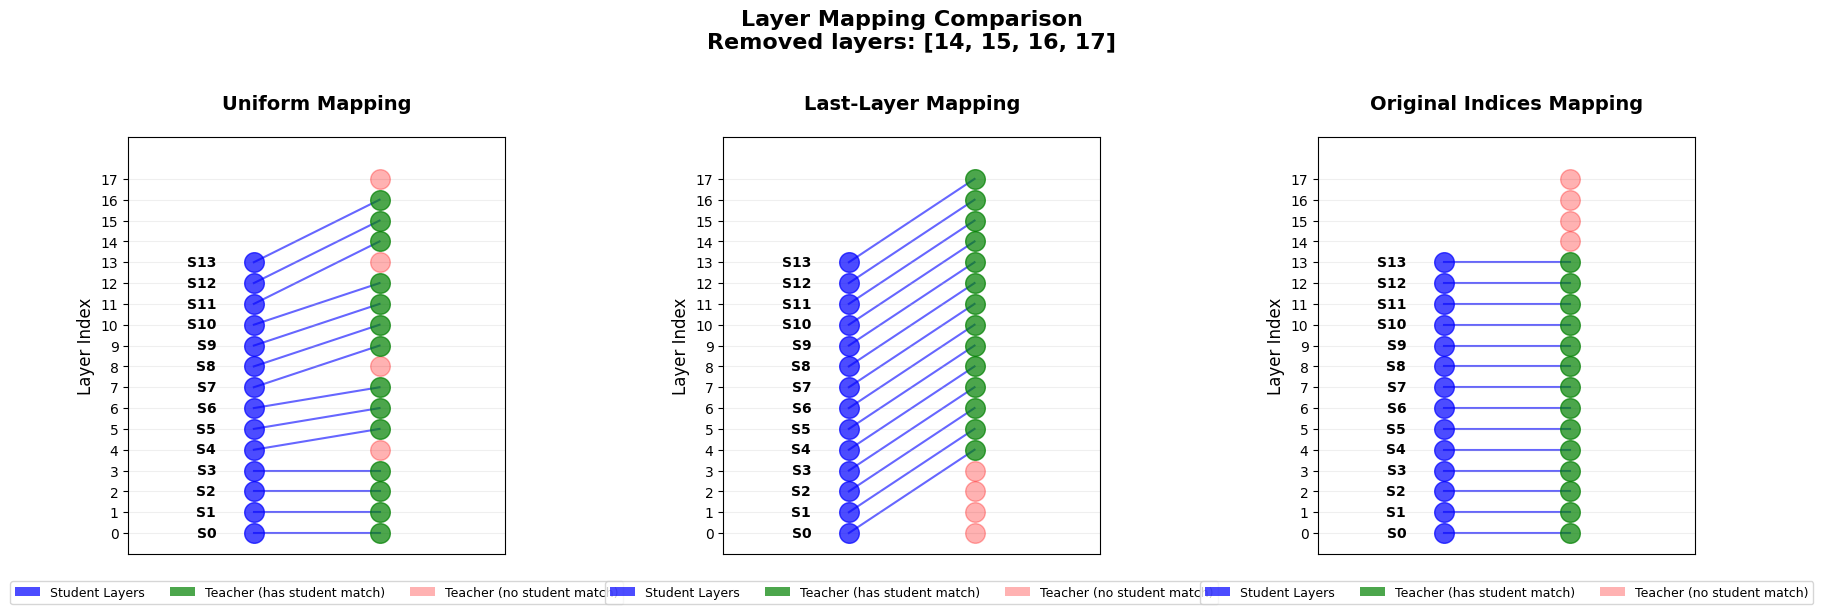

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_layer_mappings_comparison(
    n_student,
    n_teacher,
    removed_layers,
    uniform_map,
    last_map,
    original_map
):
    """
    Visualize the three mapping types in a clear comparison
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    mappings = [
        ("Uniform Mapping", uniform_map),
        ("Last-Layer Mapping", last_map),
        ("Original Indices Mapping", original_map)
    ]

    for idx, (title, mapping) in enumerate(mappings):
        ax = axes[idx]

        # Config limits
        ax.set_xlim(-1, 2)
        ax.set_ylim(-1, max(n_teacher, n_student) + 1)

        # Draw student transformer blocks (left)
        student_x = 0
        for i in range(n_student):
            ax.scatter(student_x, i, s=200, c='blue', zorder=3, alpha=0.7)
            ax.text(student_x - 0.3, i, f'S{i}', fontsize=10,
                   ha='right', va='center', fontweight='bold')

        # Draw teacher transformer blocks (right)
        teacher_x = 1
        mapped_teachers = set(mapping)

        for i in range(n_teacher):
            color = 'green' if i in mapped_teachers else 'red'  # DYNAMIC
            alpha = 0.7 if i in mapped_teachers else 0.3
            ax.scatter(teacher_x, i, s=200, c=color, zorder=3, alpha=alpha)

        # Draw connections
        for student_idx, teacher_idx in enumerate(mapping):
          # All connections are valid - always blue line
          ax.plot([student_x, teacher_x],
                [student_idx, teacher_idx],
                '-',  # solid line
                color='blue',
                linewidth=1.5,
                alpha=0.6,
                zorder=1)


        # Labels & Tittle
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.set_yticks(range(max(n_teacher, n_student)))
        ax.set_xticks([])
        ax.set_ylabel('Transformer Block Index', fontsize=12)
        ax.grid(True, alpha=0.2, axis='y')

        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.7, label='Student Transformer Blocks'),
            Patch(facecolor='green', alpha=0.7, label='Teacher (has student match)'),
            Patch(facecolor='red', alpha=0.3, label='Teacher (no student match)')  # CLEAR
        ]
        ax.legend(handles=legend_elements, loc='upper center',
                 bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=9)

    plt.suptitle(f'Transformer Block Mapping Comparison\nRemoved blocks: {sorted(removed_layers)}',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# ===== use visualization =====
visualize_layer_mappings_comparison(
    n_student=n_student_layers,
    n_teacher=n_teacher_layers,
    removed_layers=LAYERS_TO_REMOVE,
    uniform_map=uniform_map,
    last_map=last_map,
    original_map=layer_map
)


## Section 4: Implement Compound Loss

In [18]:
def compute_compound_loss(
    student_logits,
    teacher_logits,
    student_hiddens,
    teacher_hiddens,
    labels,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0
):
    """
    Compound loss with Cosine Similarity for feature alignment.

    Uses cosine similarity instead of MSE to avoid scale issues:
    - MSE can produce values in the hundreds of thousands
    - Cosine similarity is normalized and bounded [0, 2]
    - Measures directional alignment, not magnitude
    """
    # 1. TASK LOSS (Cross-Entropy)
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # 2. LOGITS LOSS (KL Divergence)
    student_soft = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=-1)

    student_soft = student_soft[..., :-1, :].contiguous()
    teacher_soft = teacher_soft[..., :-1, :].contiguous()

    loss_logits = F.kl_div(
        student_soft.view(-1, student_soft.size(-1)),
        teacher_soft.view(-1, teacher_soft.size(-1)),
        reduction='batchmean'
    ) * (temperature ** 2)

    # 3. HIDDEN STATES LOSS (Cosine Similarity)
    if gamma > 0:
      loss_hidden = 0.0
      num_aligned_layers = len(layer_map)

      for student_idx, teacher_idx in enumerate(layer_map):
          student_h = student_hiddens[student_idx]
          teacher_h = teacher_hiddens[teacher_idx]

          # Flatten: [batch * seq_len, hidden_dim]
          student_flat = student_h.reshape(-1, student_h.size(-1))
          teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

          # Normalize vectors to unit length
          student_norm = F.normalize(student_flat, p=2, dim=1)
          teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

          # Cosine similarity: dot product of normalized vectors
          # Range: [-1, 1], where 1 = perfectly aligned
          cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()

          # Convert to loss: 1 - cos_sim
          # Range: [0, 2], where 0 = perfect alignment
          loss_hidden += (1 - cos_sim)

      loss_hidden = loss_hidden / num_aligned_layers
    else:
      loss_hidden = torch.tensor(0.0, device=student_logits.device)

    # COMBINE ALL LOSSES
    total_loss = alpha * loss_task + beta * loss_logits + gamma * loss_hidden

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'hidden': loss_hidden.item()
    }

    return total_loss, loss_dict

## Section 5: Training Loop Implementation

In [19]:
import time

def train_student(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with compound loss and gradient accumulation

    Returns:
        trained_model, loss_history, training_time_seconds
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    request_hidden_states = (gamma > 0)

    loss_history = {'total': [], 'task': [], 'logits': [], 'hidden': []}
    epoch_times = []  # Tiempo por epoch



    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, T={temperature}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {'total': [], 'task': [], 'logits': [], 'hidden': []}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            loss, loss_dict = compute_compound_loss(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha, beta=beta, gamma=gamma, temperature=temperature
            )

            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'hidden': f"{avg_losses['hidden']:.4f}"
                })

                accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
                accumulation_counter = 0

        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        for key in epoch_losses:
            if epoch_losses[key]:
                avg_loss = np.mean(epoch_losses[key])
                loss_history[key].append(avg_loss)

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Hidden: {loss_history['hidden'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time

    # Add times to history
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history

In [20]:
def train_student_advanced(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    # Loss weights
    alpha=0.1,           # Task loss
    beta=0.8,            # Skew KLD (logits)
    gamma=0.05,          # Trajectory loss (hidden states)
    delta=0.05,          # FDD derivative loss
    temperature=2.0,
    skew_alpha=0.5,      # Skew interpolation factor
    # Training params
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with Advanced Compound Loss (Skew KLD + FDD).
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    # Decide if we need hidden states (required if using trajectory OR derivative loss)
    request_hidden_states = (gamma > 0 or delta > 0)

    loss_history = {
        'total': [], 'task': [], 'logits': [],
        'trajectory': [], 'derivative': []
    }
    epoch_times = []

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
    print(f"Temperature: {temperature}, Skew α: {skew_alpha}")
    print(f"Hidden states computation: {'ENABLED' if request_hidden_states else 'DISABLED'}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {k: [] for k in loss_history.keys()}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {k: 0.0 for k in loss_history.keys()}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            # Student forward pass
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            # Prepare hidden states (None if not needed)
            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            # Compute advanced compound loss
            loss, loss_dict = compute_compound_loss_advanced(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                delta=delta,
                temperature=temperature,
                skew_alpha=skew_alpha
            )

            # Gradient accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            # Optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'traj': f"{avg_losses['trajectory']:.4f}",
                    'deriv': f"{avg_losses['derivative']:.4f}"
                })

                accumulated_losses = {k: 0.0 for k in loss_history.keys()}
                accumulation_counter = 0

        # Handle remaining batches
        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        # Record epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:
                loss_history[key].append(np.mean(epoch_losses[key]))

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Traj: {loss_history['trajectory'][-1]:.4f}, "
              f"Deriv: {loss_history['derivative'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history


def compute_compound_loss_advanced(
    student_logits,      # [batch, seq_len, vocab_size]
    teacher_logits,      # [batch, seq_len, vocab_size]
    student_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    teacher_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    labels,              # [batch, seq_len]
    layer_map,           # List of teacher indices for each student layer
    alpha=0.1,           # weight for task loss
    beta=0.8,            # weight for logits loss (Skew KLD)
    gamma=0.1,           # weight for hidden trajectory loss
    delta=0.1,           # weight for FDD derivative loss
    temperature=2.0,     # temperature for soft labels
    skew_alpha=0.1       # interpolation factor for Skew KLD (0=Forward, 1=Reverse)
):
    """
    Advanced compound loss combining state-of-the-art techniques:

    1. Task Loss: Standard cross-entropy with hard labels
    2. Skew KLD: Interpolates between Forward and Reverse KLD (DistiLLM-2)
       - Forward KLD (α=0): Student covers all teacher modes (mean-seeking)
       - Reverse KLD (α=1): Student focuses on high-confidence modes (mode-seeking)
       - Skew (α=0.1): Best of both worlds, numerically stable
    3. Trajectory Loss: Cosine similarity between hidden states (standard feature KD)
    4. FDD Derivative Loss: Aligns the "rate of change" between consecutive layers
       - Forces student to learn HOW to transform representations, not just WHAT to produce
       - Critical for depth-pruned models that must take "bigger steps" with fewer layers

    Reference:
    - Skew KLD: DistiLLM-2 (2024)
    - FDD: Feature Dynamics Distillation, ACL 2025
    """
    device = student_logits.device

    # =========================================================================
    # 1. TASK LOSS (Cross-Entropy with hard labels)
    # =========================================================================
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # =========================================================================
    # 2. SKEW KLD (Interpolated Divergence for Logits)
    # =========================================================================
    # Standard softmax with temperature
    with torch.no_grad():
        student_probs = F.softmax(student_logits[..., :-1, :] / temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits[..., :-1, :] / temperature, dim=-1)

        # Skew: interpolate between teacher and student distributions
        # When skew_alpha=0.1: 90% teacher + 10% student (slight mode-seeking bias)
        mixed_probs = skew_alpha * student_probs + (1 - skew_alpha) * teacher_probs

    # KL divergence against the mixed target
    student_log_probs = F.log_softmax(student_logits[..., :-1, :] / temperature, dim=-1)
    kl_elementwise = student_probs * (student_log_probs - torch.log(mixed_probs + 1e-9))
    loss_logits = kl_elementwise.sum(dim=-1).mean() * (temperature ** 2)

    # =========================================================================
    # 3. TRAJECTORY LOSS (Cosine Similarity of Hidden States)
    # =========================================================================
    # Standard feature alignment - matches "where" the student is in representation space
    # Only compute if gamma > 0 and we have hidden states
    if gamma > 0 and student_hiddens is not None and teacher_hiddens is not None:
        loss_trajectory = 0.0
        for student_idx, teacher_idx in enumerate(layer_map):
            student_h = student_hiddens[student_idx]
            teacher_h = teacher_hiddens[teacher_idx]

            # Flatten and normalize
            student_flat = student_h.reshape(-1, student_h.size(-1))
            teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))
            student_norm = F.normalize(student_flat, p=2, dim=1)
            teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

            # Cosine similarity loss: 1 - cos_sim (0 = perfect alignment)
            cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()
            loss_trajectory += (1 - cos_sim)

        loss_trajectory = loss_trajectory / len(layer_map)
    else:
        loss_trajectory = torch.tensor(0.0, device=device)

    # =========================================================================
    # 4. FDD DERIVATIVE LOSS (Feature Dynamics Distillation)
    # =========================================================================
    # Matches the "velocity" of representation change between consecutive layers
    # Key insight: In residual networks, x_{l+1} = x_l + F(x_l)
    # The delta F(x_l) represents how much the layer transforms the representation
    # A depth-pruned student must learn to make larger, more efficient transformations
    # Only compute if delta > 0 and we have hidden states
    loss_derivative = torch.tensor(0.0, device=device)

    if delta > 0 and student_hiddens is not None and teacher_hiddens is not None:
        num_derivatives = 0

        for student_idx in range(len(layer_map) - 1):
            teacher_idx = layer_map[student_idx]
            teacher_idx_next = layer_map[student_idx + 1]

            # Student delta: change between consecutive student layers
            student_delta = student_hiddens[student_idx + 1] - student_hiddens[student_idx]

            # Teacher delta: change between corresponding teacher layers
            teacher_delta = teacher_hiddens[teacher_idx_next] - teacher_hiddens[teacher_idx]

            # Flatten and normalize the deltas
            student_delta_flat = student_delta.reshape(-1, student_delta.size(-1))
            teacher_delta_flat = teacher_delta.reshape(-1, teacher_delta.size(-1))

            student_delta_norm = F.normalize(student_delta_flat, p=2, dim=1)
            teacher_delta_norm = F.normalize(teacher_delta_flat, p=2, dim=1)

            # Cosine similarity of derivatives
            cos_sim_deriv = (student_delta_norm * teacher_delta_norm).sum(dim=1).mean()
            loss_derivative += (1 - cos_sim_deriv)
            num_derivatives += 1

        if num_derivatives > 0:
            loss_derivative = loss_derivative / num_derivatives

    # =========================================================================
    # COMBINE ALL LOSSES
    # =========================================================================
    total_loss = (
        alpha * loss_task +
        beta * loss_logits +
        gamma * loss_trajectory +
        delta * loss_derivative
    )

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'trajectory': loss_trajectory.item(),
        'derivative': loss_derivative.item()
    }

    return total_loss, loss_dict

## Section 6: Experiment A - Transformer Block Mapping Comparison (Labels-Only)

In [21]:
clear_gpu_cache()

In [ ]:
# Create fresh student model
student_last = deepcopy(student_model)

# Create last-layer mapping
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

# Train with labels-only (gamma=0.0)
student_last_trained, history_last = train_student(
    student_model=student_last,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_map,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Last-Layer Mapping + Labels-Only"
)

In [23]:
print("Evaluating Last-Layer + Labels-only...")
last_metrics = evaluate_metrics(student_last_trained, eval_dataloader, device=device)
last_loss = last_metrics['loss']
last_ppl = last_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_last_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['last_layer_labels_only'] = results



Evaluating Last-Layer + Labels-only...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.84it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:41<00:00, 40.15it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 109.60it/s]


In [24]:
del student_last, student_last_trained
clear_gpu_cache()

## Section 7: Experiment B - Adding Feature Alignment

In [ ]:
print("\n" + "="*60)
print("EXPERIMENT B: Adding Feature Alignment")
print("Configuration: Last-Layer Mapping + Full Compound Loss")
print("="*60)

# Train with FULL compound loss (including hidden states)
student_features_trained, history_features = train_student(
    student_model=deepcopy(student_model),
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,  # NOW we include hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Last-Layer + Features"
)

In [26]:
print("Evaluating Last-Layer + Features...")
features_metrics = evaluate_metrics(student_features_trained, eval_dataloader, device=device)
features_loss = features_metrics['loss']
features_ppl = features_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_features_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['last_layer_features'] = results

Evaluating Last-Layer + Features...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.84it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:41<00:00, 40.12it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 122.78it/s]


In [27]:
del student_features_trained
clear_gpu_cache()

In [ ]:
print("\n" + "="*60)
print("Configuration: Selected-Layer Mapping + Full Compound Loss")
print("="*60)

# Train with FULL compound loss (including hidden states)
student_sel_features_trained, history_sel_features = train_student(
    student_model=deepcopy(student_model),
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,  # NOW we include hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected-Layer + Features"
)

In [29]:
print("Evaluating Selected-Layer + Features...")
sel_features_metrics = evaluate_metrics(student_sel_features_trained, eval_dataloader, device=device)
sel_features_loss = sel_features_metrics['loss']
sel_features_ppl = sel_features_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_sel_features_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['selected_layer_features'] = results


Evaluating Selected-Layer + Features...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.81it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:41<00:00, 40.12it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 120.17it/s]


In [30]:
del student_sel_features_trained
clear_gpu_cache()

## Section 8: Experiment C - Advanced KD (Skew KLD + FDD)


In [31]:
print("\n" + "="*60)
print("EXPERIMENT C: Advanced Knowledge Distillation")
print("Configuration: Uniform-Layer Mapping + Skew KLD + FDD")
print("="*60)



EXPERIMENT C: Advanced Knowledge Distillation
Configuration: Uniform-Layer Mapping + Skew KLD + FDD


In [ ]:
# Train with Advanced KD
student_uni_advanced_trained, history_uni_advanced = train_student_advanced(
    student_model=deepcopy(student_model),
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=uniform_map,
    alpha=0.2,           # Task loss weight
    beta=0.5,            # Skew KLD weight
    gamma=0.1,           # Trajectory (hidden) weight
    delta=0.2,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Uniform Layers Advanced KD (Skew KLD + FDD)"
)

In [33]:
# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_uni_metrics = evaluate_metrics(student_uni_advanced_trained, eval_dataloader, device=device)
advanced_uni_loss = advanced_uni_metrics['loss']
advanced_uni_ppl = advanced_uni_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_uni_advanced_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['uniform_advanced_kd'] = results


Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.84it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:42<00:00, 39.98it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 120.71it/s]


In [34]:
del student_uni_advanced_trained
clear_gpu_cache()

In [35]:
print("\n" + "="*60)
print("EXPERIMENT C: Advanced Knowledge Distillation")
print("Configuration: Selected-Layer Mapping + Skew KLD + FDD")
print("="*60)




EXPERIMENT C: Advanced Knowledge Distillation
Configuration: Selected-Layer Mapping + Skew KLD + FDD


In [ ]:
# Train with Advanced KD
student_sel_advanced_trained, history_sel_advanced = train_student_advanced(
    student_model=deepcopy(student_model),
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=layer_map,
    alpha=0.2,           # Task loss weight
    beta=0.5,            # Skew KLD weight
    gamma=0.1,           # Trajectory (hidden) weight
    delta=0.2,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected Layers Advanced KD (Skew KLD + FDD)"
)

In [37]:
# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_sel_metrics = evaluate_metrics(student_sel_advanced_trained, eval_dataloader, device=device)
advanced_sel_loss = advanced_sel_metrics['loss']
advanced_sel_ppl = advanced_sel_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_sel_advanced_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['selected_advanced_kd'] = results

Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.82it/s]


Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=500)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 6498/6498 [02:43<00:00, 39.63it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 113.49it/s]


In [38]:
del student_sel_advanced_trained
clear_gpu_cache()

## Section 9: Evaluation and Comparison

In [39]:
# Calculate recovery rates
def recovery_rate(teacher_ppl, pruned_ppl, recovered_ppl):
    """Calculate recovery rate as percentage"""
    degradation = pruned_ppl - teacher_ppl
    recovery = pruned_ppl - recovered_ppl
    return (recovery / degradation) * 100 if degradation > 0 else 0




In [40]:
last_recovery = recovery_rate(teacher_ppl, student_ppl, last_ppl)
features_recovery = recovery_rate(teacher_ppl, student_ppl, features_ppl)
sel_features_recovery = recovery_rate(teacher_ppl, student_ppl, sel_features_ppl)
advanced_sel_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_sel_ppl)
advanced_uni_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_uni_ppl)

# Print results table
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<40} {'Loss':>10} {'Perplexity':>12} {'Recovery':>12}")
print("-"*80)
print(f"{'Teacher (Original)':<40} {teacher_loss:>10.4f} {teacher_ppl:>12.2f} {'100.0%':>12}")
print(f"{'Student (Pruned, no training)':<40} {student_loss:>10.4f} {student_ppl:>12.2f} {'0.0%':>12}")
print("-"*80)
print(f"{'Last-Layer + Labels-only':<40} {last_loss:>10.4f} {last_ppl:>12.2f} {f'{last_recovery:.1f}%':>12}")
print(f"{'Last-Layer + Features (Cosine)':<40} {features_loss:>10.4f} {features_ppl:>12.2f} {f'{features_recovery:.1f}%':>12}")
print(f"{'Selected-Layer + Features (Cosine)':<40} {sel_features_loss:>10.4f} {sel_features_ppl:>12.2f} {f'{sel_features_recovery:.1f}%':>12}")
print(f"{'Uniform  (Skew KLD + FDD)':<40} {advanced_uni_loss:>10.4f} {advanced_uni_ppl:>12.2f} {f'{advanced_uni_recovery:.1f}%':>12}")
print(f"{'Selected  (Skew KLD + FDD)':<40} {advanced_sel_loss:>10.4f} {advanced_sel_ppl:>12.2f} {f'{advanced_sel_recovery:.1f}%':>12}")
print("="*80)


EVALUATION RESULTS
Model                                          Loss   Perplexity     Recovery
--------------------------------------------------------------------------------
Teacher (Original)                           2.5942        13.39       100.0%
Student (Pruned, no training)                5.5748       263.69         0.0%
--------------------------------------------------------------------------------
Last-Layer + Labels-only                     3.3602        28.80        93.8%
Last-Layer + Features (Cosine)               3.3552        28.65        93.9%
Selected-Layer + Features (Cosine)           3.3487        28.47        94.0%
Uniform  (Skew KLD + FDD)                    3.1790        24.02        95.8%
Selected  (Skew KLD + FDD)                   3.1584        23.53        95.9%


In [41]:
# Section 9: Benchmark Evaluation
if RUN_FULL_BENCHMARKS:

    # Display comparison table
    print("\n" + "="*90)
    print("BENCHMARK COMPARISON TABLE")
    print("="*90)

    # Header
    header = f"{'Model':<25}"
    for task in BENCHMARK_TASKS:
        header += f"{task:<14}"

    print(header)
    print("-"*90)

    # Rows
    for model_name, results in benchmark_results.items():
        row = f"{model_name:<25}"
        for task in BENCHMARK_TASKS:
            if task in results and "error" not in results:
                # Get accuracy or acc_norm depending on task
                metrics = results[task]
                if "acc_norm" in metrics:
                    val = float(metrics["acc_norm"])
                elif "accuracy" in metrics:
                    val = float(metrics["accuracy"])
                else:
                    val = 0.0
                row += f"{val:.4f}        "
            else:
                row += f"{'N/A':<14}"
        print(row)

    print("="*90)

else:
    print("⚠️ Benchmark evaluation skipped (RUN_FULL_BENCHMARKS = False)")
    benchmark_results = {}


BENCHMARK COMPARISON TABLE
Model                    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
------------------------------------------------------------------------------------------
teacher                  0.5820        0.5500        0.4740        0.4220        0.7020        
student_pruned           0.4000        0.5120        0.3620        0.2300        0.5700        
last_layer_labels_only   0.4420        0.5220        0.4040        0.2740        0.5980        
last_layer_features      0.4440        0.5180        0.4040        0.2720        0.5980        
selected_layer_features  0.4400        0.5100        0.4060        0.2700        0.6020        
uniform_advanced_kd      0.4180        0.5140        0.4160        0.3020        0.5940        
selected_advanced_kd     0.4280        0.5100        0.4280        0.2800        0.6020        


## Section 10: Visualization

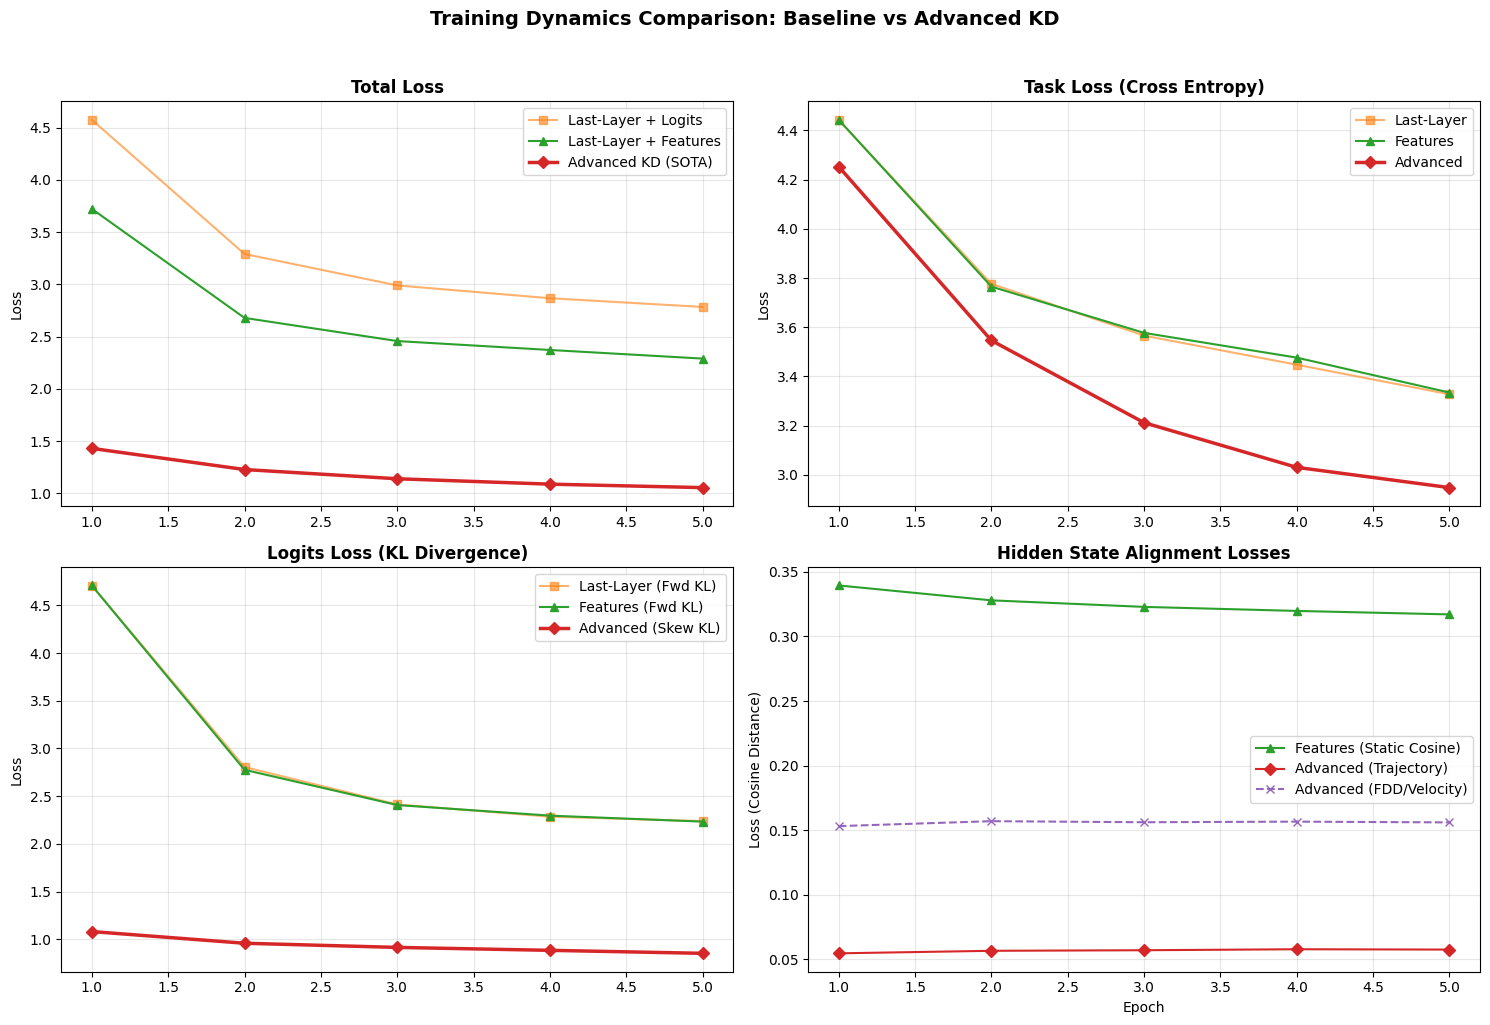

✓ Loss comparison plots generated successfully


In [42]:
import matplotlib.pyplot as plt

colors = {'uniform': '#1f77b4', 'last': '#ff7f0e', 'features': '#2ca02c', 'advanced': '#d62728', 'deriv': '#9467bd'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Use the Selected Advanced KD history (or change to history_uni_advanced if you prefer)
epochs_x = list(range(1, len(history_sel_advanced['total']) + 1))

# --- PLOT 1: Total Loss ---
axes[0, 0].plot(epochs_x, history_last['total'], 's-', label='Last-Layer + Logits', color=colors['last'], alpha=0.6)
axes[0, 0].plot(epochs_x, history_features['total'], '^-', label='Last-Layer + Features', color=colors['features'])
axes[0, 0].plot(epochs_x, history_sel_advanced['total'], 'D-', label='Advanced KD (SOTA)', color=colors['advanced'], linewidth=2.5)

axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- PLOT 2: Task Loss ---
axes[0, 1].plot(epochs_x, history_last['task'], 's-', label='Last-Layer', color=colors['last'], alpha=0.6)
axes[0, 1].plot(epochs_x, history_features['task'], '^-', label='Features', color=colors['features'])
axes[0, 1].plot(epochs_x, history_sel_advanced['task'], 'D-', label='Advanced', color=colors['advanced'], linewidth=2.5)

axes[0, 1].set_title('Task Loss (Cross Entropy)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- PLOT 3: Logits Loss ---
axes[1, 0].plot(epochs_x, history_last['logits'], 's-', label='Last-Layer (Fwd KL)', color=colors['last'], alpha=0.6)
axes[1, 0].plot(epochs_x, history_features['logits'], '^-', label='Features (Fwd KL)', color=colors['features'])
axes[1, 0].plot(epochs_x, history_sel_advanced['logits'], 'D-', label='Advanced (Skew KL)', color=colors['advanced'], linewidth=2.5)

axes[1, 0].set_title('Logits Loss (KL Divergence)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- PLOT 4: Hidden/Structural Losses ---
axes[1, 1].plot(epochs_x, history_features['hidden'], '^-', label='Features (Static Cosine)', color=colors['features'])
axes[1, 1].plot(epochs_x, history_sel_advanced['trajectory'], 'D-', label='Advanced (Trajectory)', color=colors['advanced'])
axes[1, 1].plot(epochs_x, history_sel_advanced['derivative'], 'x--', label='Advanced (FDD/Velocity)', color=colors['deriv'])

axes[1, 1].set_title('Hidden State Alignment Losses', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss (Cosine Distance)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training Dynamics Comparison: Baseline vs Advanced KD',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Loss comparison plots generated successfully")

In [43]:
print("="*120)
print("COMPLETE EVALUATION RESULTS (With Training Time)")
print("="*120)

training_times = {
    "teacher": 0.0,
    "student_pruned": 0.0,
    "last_layer_labels_only": history_last['total_time_seconds'],
    "last_layer_features": history_features['total_time_seconds'],
    "uniform_advanced_kd": history_uni_advanced['total_time_seconds'],      # ✅ Changed
    "selected_advanced_kd": history_sel_advanced['total_time_seconds']      # ✅ Changed
}

all_metrics = {
    "teacher": {
        "time_min": training_times["teacher"] / 60,
        "perplexity": teacher_ppl,
        "recovery_%": 100.0
    },
    "student_pruned": {
        "time_min": training_times["student_pruned"] / 60,
        "perplexity": student_ppl,
        "recovery_%": 0.0
    },
    # --- Experiment A: Labels Only ---
    "last_layer_labels_only": {
        "time_min": training_times["last_layer_labels_only"] / 60,
        "perplexity": last_ppl,
        "recovery_%": last_recovery
    },
    # --- Experiment B: Features ---
    "last_layer_features": {
        "time_min": training_times["last_layer_features"] / 60,
        "perplexity": features_ppl,
        "recovery_%": features_recovery
    },
    "selected_layer_features": {
        "time_min": training_times["last_layer_features"] / 60,
        "perplexity": sel_features_ppl if 'sel_features_ppl' in locals() else 0,
        "recovery_%": sel_features_recovery if 'sel_features_recovery' in locals() else 0
    },
    # --- Experiment C: Advanced KD ---
    "uniform_advanced_kd": {
        "time_min": training_times["uniform_advanced_kd"] / 60,              # ✅ Changed
        "perplexity": advanced_uni_ppl,
        "recovery_%": advanced_uni_recovery
    },
    "selected_advanced_kd": {
        "time_min": training_times["selected_advanced_kd"] / 60,             # ✅ Changed
        "perplexity": advanced_sel_ppl,
        "recovery_%": advanced_sel_recovery
    }
}

if 'benchmark_results' in locals() and benchmark_results:
    for model_name in all_metrics.keys():
        if model_name in benchmark_results and "error" not in benchmark_results[model_name]:
            for task_name, task_metrics in benchmark_results[model_name].items():
                if "acc_norm" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["acc_norm"])
                elif "accuracy" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["accuracy"])

metric_names = ["time_min", "perplexity", "recovery_%"]
if 'benchmark_results' in locals() and benchmark_results:
    metric_names.extend(BENCHMARK_TASKS)

header = f"{'Model':<25}"
labels = {"time_min": "Time(m)", "perplexity": "PPL", "recovery_%": "Recov%"}

for metric in metric_names:
    label = labels.get(metric, metric)
    header += f"{label:<10}"
print(header)
print("-" * 120)

for model_name, metrics in all_metrics.items():
    row = f"{model_name:<25}"
    for metric in metric_names:
        if metric in metrics:
            val = metrics[metric]
            if metric == "time_min":
                row += f"{val:<10.1f}" if val > 0 else f"{'-':<10}"
            elif metric == "perplexity":
                row += f"{val:<10.2f}"
            elif metric == "recovery_%":
                row += f"{val:<10.1f}"
            else:
                row += f"{val*100:<10.1f}"
        else:
            row += f"{'N/A':<10}"
    print(row)
print("="*120)

COMPLETE EVALUATION RESULTS (With Training Time)
Model                    Time(m)   PPL       Recov%    arc_easy  winograndehellaswag lambada_openaipiqa      
------------------------------------------------------------------------------------------------------------------------
teacher                  -         13.39     100.0     58.2      55.0      47.4      42.2      70.2      
student_pruned           -         263.69    0.0       40.0      51.2      36.2      23.0      57.0      
last_layer_labels_only   3.6       28.80     93.8      44.2      52.2      40.4      27.4      59.8      
last_layer_features      3.7       28.65     93.9      44.4      51.8      40.4      27.2      59.8      
selected_layer_features  3.7       28.47     94.0      44.0      51.0      40.6      27.0      60.2      
uniform_advanced_kd      4.0       24.02     95.8      41.8      51.4      41.6      30.2      59.4      
selected_advanced_kd     4.0       23.53     95.9      42.8      51.0      42.8     

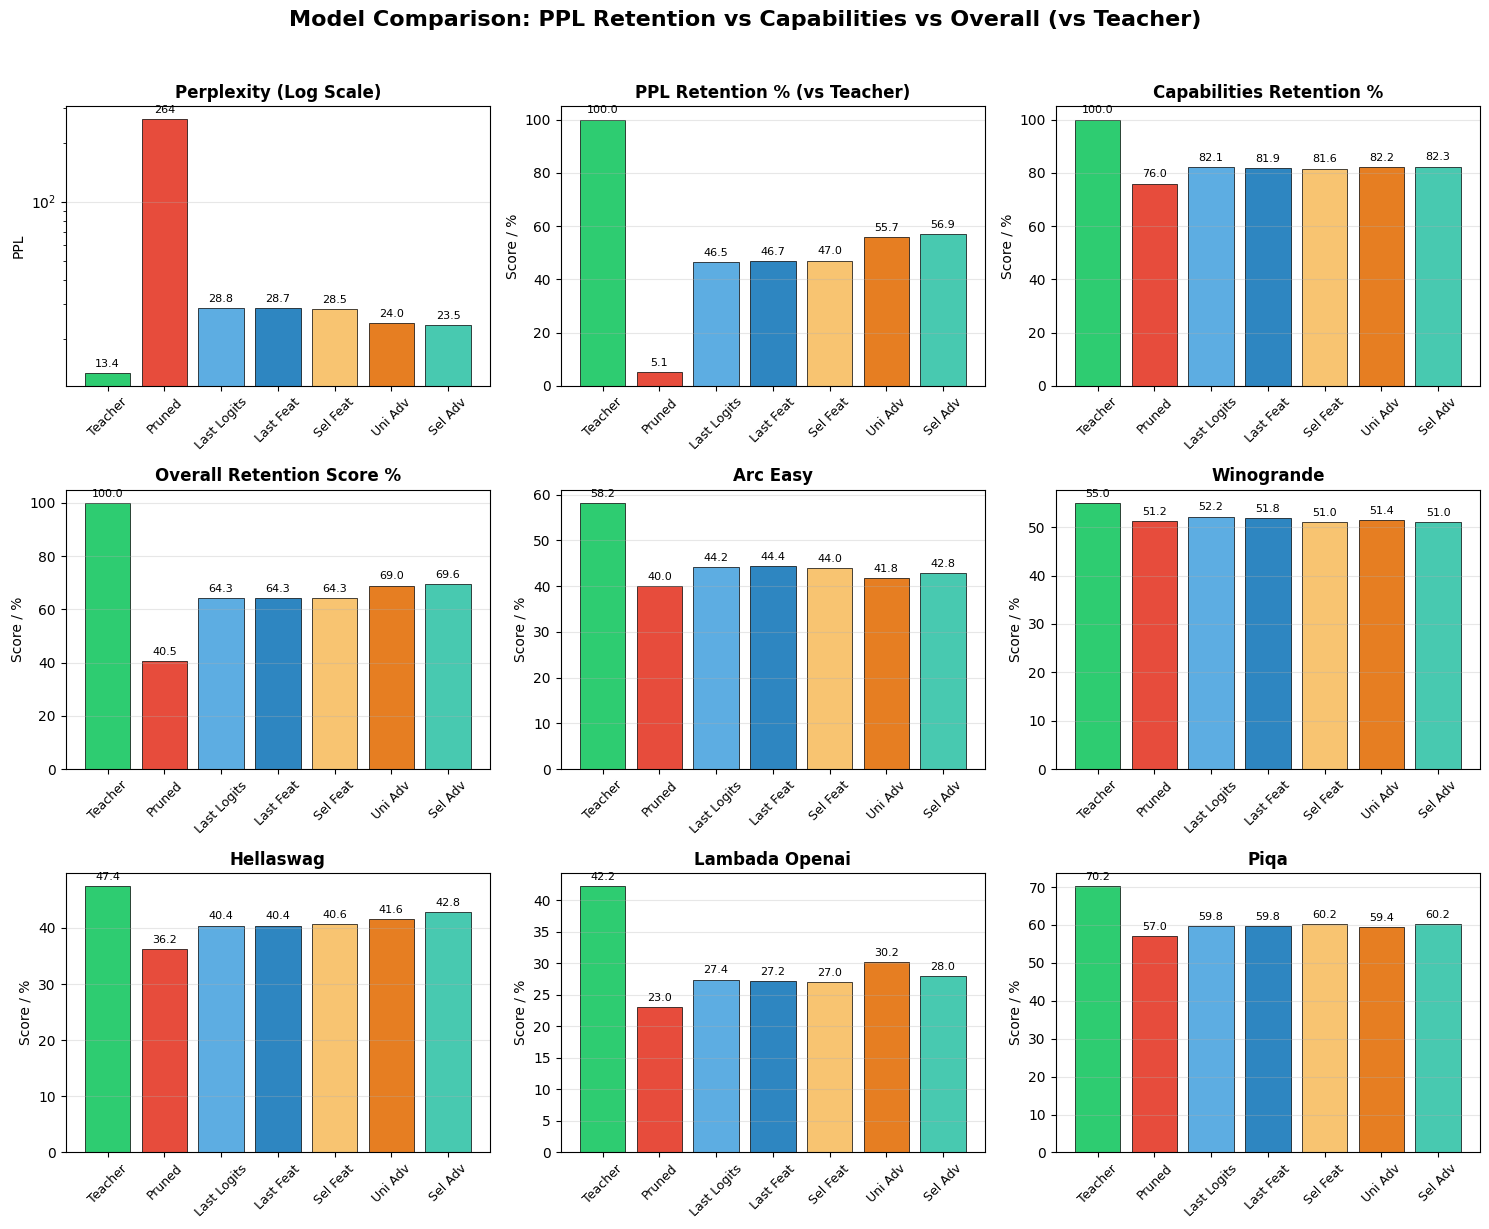

✓ Charts Updated: Now showing PPL Retention % and Overall Retention Score % (vs Teacher)


In [44]:
# ==============================================================================
# 10.2 Bar Charts: PPL Retention & Overall Retention (vs Teacher)
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP: Models, Names and Colors
model_display_names = {
    "teacher": "Teacher",
    "student_pruned": "Pruned",
    "last_layer_labels_only": "Last Logits",
    "last_layer_features": "Last Feat",
    "selected_layer_features": "Sel Feat",
    "uniform_advanced_kd": "Uni Adv",
    "selected_advanced_kd": "Sel Adv"
}

# Ensure correct order based on availability
model_order = [m for m in model_display_names.keys() if m in all_metrics]

colors = [
    '#2ecc71',  # Teacher (Green)
    '#e74c3c',  # Pruned (Red)
    '#5dade2', '#2e86c1',  # Logits (Blues)
    '#f8c471', '#e67e22',  # Features (Oranges)
    '#48c9b0', '#16a085'   # Advanced (Teals)
]

# 2. CRITICAL FIX: INJECT BENCHMARKS INTO all_metrics
bench_tasks = ["arc_easy", "winogrande", "hellaswag", "lambada_openai", "piqa"]

if 'benchmark_results' in locals():
    for model_key in model_order:
        if model_key in benchmark_results:
            res = benchmark_results[model_key]
            if "error" not in res:
                for task in bench_tasks:
                    if task in res:
                        val = 0.0
                        if "acc_norm" in res[task]:
                            val = float(res[task]["acc_norm"])
                        elif "accuracy" in res[task]:
                            val = float(res[task]["accuracy"])

                        # Save into all_metrics for calculation
                        all_metrics[model_key][task] = val

# 3. CALCULATE RETENTION METRICS (vs Teacher)
# Get Teacher Baselines
teacher_vals = [all_metrics['teacher'].get(t, 0) for t in bench_tasks]
teacher_avg_acc = np.mean(teacher_vals) if teacher_vals else 0
teacher_ppl = all_metrics['teacher'].get('perplexity', 0)

for model_name in model_order:
    if model_name not in all_metrics:
        continue

    # A. Capabilities Retention (% of teacher performance on Benchmarks)
    if bench_tasks and teacher_avg_acc > 0:
        current_vals = [all_metrics[model_name].get(t, 0) for t in bench_tasks]
        current_avg = np.mean(current_vals)
        cap_retention = (current_avg / teacher_avg_acc) * 100
    else:
        cap_retention = 0.0

    all_metrics[model_name]['cap_retention_%'] = cap_retention

    # B. PPL Retention (% of Teacher PPL) - NEW CALCULATION
    # Formula: (Teacher PPL / Student PPL) * 100
    # Lower PPL is better, so if Student PPL is higher, retention drops
    curr_ppl = all_metrics[model_name].get('perplexity', float('inf'))

    if curr_ppl > 0 and teacher_ppl > 0:
        ppl_retention = (teacher_ppl / curr_ppl) * 100
    else:
        ppl_retention = 0.0

    # Store as 'retention_%' (renamed from 'recovery_%')
    all_metrics[model_name]['retention_%'] = ppl_retention

    # C. Overall Retention Score (Average of PPL Retention and Cap Retention)
    if cap_retention > 0:
        all_metrics[model_name]['overall_retention_%'] = (ppl_retention + cap_retention) / 2
    else:
        all_metrics[model_name]['overall_retention_%'] = ppl_retention

# 4. PREPARE PLOTS
summary_metrics = ["perplexity", "retention_%", "cap_retention_%", "overall_retention_%"]
metrics_to_plot = summary_metrics + bench_tasks

# Titles map - UPDATED
metric_titles = {
    "perplexity": "Perplexity (Log Scale)",
    "retention_%": "PPL Retention % (vs Teacher)",
    "cap_retention_%": "Capabilities Retention %",
    "overall_retention_%": "Overall Retention Score %",
}

# Grid Setup
n_metrics = len(metrics_to_plot)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_metrics > 1 else [axes]

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = []
    labels = []
    bar_colors = []

    for i, model_name in enumerate(model_order):
        if model_name in all_metrics:
            # Safely get value
            val = all_metrics[model_name].get(metric, 0.0)

            # Conversion logic: Multiply raw benchmarks (0.0-1.0) by 100 for plotting
            # Do NOT multiply metrics that are already % (perplexity, retention)
            if metric not in ["perplexity", "retention_%", "cap_retention_%", "overall_retention_%", "time_min"]:
                val = val * 100

            values.append(val)
            labels.append(model_display_names[model_name])

            # Color assignment
            c_idx = i if i < len(colors) else -1
            bar_colors.append(colors[c_idx])

    # Plot
    if values and sum(values) > 0:
        bars = ax.bar(labels, values, color=bar_colors, edgecolor='black', linewidth=0.5)

        # Annotations
        for bar, val in zip(bars, values):
            height = bar.get_height()
            if metric == "perplexity" and val > 100:
                fmt = f'{val:.0f}'
            else:
                fmt = f'{val:.1f}'

            ax.annotate(fmt,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        # Styling
        title = metric_titles.get(metric, metric.replace("_", " ").title())
        ax.set_title(title, fontsize=12, fontweight='bold')

        ylabel = "PPL" if metric == "perplexity" else "Score / %"
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(True, alpha=0.3, axis='y')

        # Log scale for PPL
        if metric == "perplexity":
            if max(values) / (min(values) + 1e-9) > 10:
                ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, "No Data Available", ha='center', va='center')
        ax.set_title(metric)

# Hide unused subplots
for idx in range(n_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Model Comparison: PPL Retention vs Capabilities vs Overall (vs Teacher)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Charts Updated: Now showing PPL Retention % and Overall Retention Score % (vs Teacher)")

# Section 11: Results & Analysis

## Key Findings

### What We Learned:

**1. Baseline Performance Establishes the Challenge**
- Teacher Model (google/gemma-3-270m, 18 transformer blocks): 13.39 PPL, 100% capability retention
- Untrained Pruned Student (14 transformer blocks): 263.69 PPL, 75.97% capability retention
- The goal: Recover as much teacher performance as possible through knowledge distillation

**2. Advanced KD is Superior: The Game-Changer**
- **Selected-Layer + Advanced KD achieves the best perplexity results**: 23.53 PPL with 82.34% capability retention
- Labels-only approaches plateau at ~28.80 PPL
- **Advanced KD provides significant perplexity improvement** over labels-only methods (23.53 vs 28.80)
- The improvement comes from Skew KLD (better distribution matching) and Feature Dynamics Distillation (trajectory alignment)
- **Training efficiency**: Advanced KD adds only ~11% training time (~4.0 min vs ~3.6 min for labels-only), making the significant performance gain highly cost-effective

**3. Benchmark Results Show Consistent Patterns Across Tasks**
- **ARC-Easy** (reasoning): 41.8-44.4% across methods (Teacher: 58.2%)
  - Best: Last-Layer + Features (44.4%)
- **HellaSwag** (common sense): 40.4-42.8% across methods (Teacher: 47.4%)
  - Best: Selected-Layer + Advanced KD (42.8%)
- **Lambada** (language modeling): 27.0-30.2% across methods (Teacher: 42.2%)
  - Best: Uniform + Advanced KD (30.2%)
- **PIQA** (physical reasoning): 59.4-60.2% across methods (Teacher: 70.2%)
  - Best: Selected-Layer + Features / Selected-Layer + Advanced KD (60.2%)
- **Winogrande** (commonsense reasoning): 51.0-52.2% across methods (Teacher: 55.0%)
  - Best: Last-Layer + Labels-only (52.2%)

**4. Transformer Block Mapping Strategy Has Modest Impact**
- Selected-Layer and Last-Layer mappings achieve slightly better perplexity than Uniform in some experiments
- Selected-Layer mapping preserves the original architectural relationships by maintaining transformer block indices from before pruning
- The mapping strategy becomes more important when combined with feature alignment

**5. Feature Alignment and Advanced KD Improve Results**
- Adding hidden state alignment (γ=0.2) and advanced KD techniques contributes to better performance
- Selected-Layer + Advanced KD achieves **82.34% capability retention** with the best perplexity (23.53)
- Advanced KD methods are particularly effective for language modeling tasks (Lambada, HellaSwag)

In [45]:
import json
import os
import torch
import numpy as np
from datetime import datetime

# ==========================================
# 1. PREPARE CONFIGURATIONS (Hyperparameters)
# ==========================================
# Reconstructed from the training calls in the notebook
configs = {
    "last_layer_labels_only": {
        "alpha": 0.5, "beta": 0.5, "gamma": 0.0, "temp": 2.0,
        "mapping": "last_layer", "description": "Labels-only KD"
    },
    "last_layer_features": {
        "alpha": 0.4, "beta": 0.4, "gamma": 0.2, "temp": 2.0,
        "mapping": "last_layer", "description": "Standard Feature Alignment (Cosine)"
    },
    "selected_layer_features": {
        "alpha": 0.4, "beta": 0.4, "gamma": 0.2, "temp": 2.0,
        "mapping": "original_indices", "description": "Standard Feature Alignment (Cosine)"
    },
    "uniform_advanced_kd": {
        "alpha": 0.2, "beta": 0.3, "gamma": 0.3, "delta": 0.2, "skew": 0.5,
        "mapping": "uniform", "description": "Skew KLD + FDD (Trajectory & Derivative)"
    },
    "selected_advanced_kd": {
        "alpha": 0.2, "beta": 0.3, "gamma": 0.3, "delta": 0.2, "skew": 0.5,
        "mapping": "original_indices", "description": "Skew KLD + FDD (Trajectory & Derivative)"
    }
}

# ==========================================
# 2. PREPARE HISTORIES
# ==========================================
# Mapping model keys to the history variables in memory.
# Note: Using locals().get() prevents crashes if a variable is missing.
histories = {
    "last_layer_labels_only": locals().get('history_last'),
    "last_layer_features": locals().get('history_features'),
    "selected_layer_features": locals().get('history_sel_features'),
    "uniform_advanced_kd": locals().get('history_uni_advanced'),
    "selected_advanced_kd": locals().get('history_sel_advanced')
}

# ==========================================
# 3. DEFINE SAVING FUNCTION
# ==========================================
class NumpyEncoder(json.JSONEncoder):
    """Helper to serialize numpy data types into JSON."""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

def save_experiment_results(
    experiment_name,
    teacher_name,
    student_name,
    all_metrics,     # The full dictionary created in Section 10.2
    histories,       # Dict mapping model_key -> history (loss_history)
    configs,         # Dict mapping model_key -> config (hyperparams)
    output_path="experiment_results.json"
):
    """
    Saves results unifying configuration, metrics, and training stats per experiment.
    """

    # Base structure
    data = {
        "metadata": {
            "experiment_name": experiment_name,
            "timestamp": datetime.now().isoformat(),
            "versions": {"torch": torch.__version__}
        },
        "models": {
            "teacher": teacher_name,
            "student": student_name
        },
        "experiments": {}
    }

    # Iterate over models present in metrics (excluding baselines that aren't trained)
    for model_key, metrics in all_metrics.items():
        if model_key in ["teacher", "student_pruned"]:
            # We can save baselines differently or skip them for the "experiments" section
            # Let's verify if we want to include baselines as reference
            data["experiments"][model_key] = {
                "type": "baseline",
                "metrics": metrics
            }
            continue

        # Initialize experiment entry
        exp_entry = {
            "type": "trained_student",
            "config": configs.get(model_key, "Config not found"),
            "metrics": metrics, # Contains PPL, Recovery, Time, Benchmarks
            "training_stats": {}
        }

        # Add training history data if available
        if model_key in histories and histories[model_key] is not None:
            hist = histories[model_key]
            # Extract exact time and final loss for quick access
            total_time = hist.get('total_time_seconds', 0)

            # Handle list vs empty list for loss
            final_loss = 0
            if 'total' in hist and len(hist['total']) > 0:
                final_loss = hist['total'][-1]

            exp_entry["training_stats"] = {
                "total_time_seconds": total_time,
                "final_loss": final_loss,
                "epochs_trained": len(hist.get('epoch_times_seconds', []))
            }
            # Optional: Save full history (loss curves)
            # exp_entry["full_history"] = hist

        data["experiments"][model_key] = exp_entry

    # Save to file using NumpyEncoder to handle float32/int64
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(data, f, indent=4, cls=NumpyEncoder)
        print(f"✓ Experiment results saved to: {output_path}")

    return data

# ==========================================
# 4. EXECUTE SAVE
# ==========================================
# Define file path
json_filename = "/content/drive/MyDrive/ch06nb01/CH06_NB_EXP03_results.json"

# Execute
final_data = save_experiment_results(
    experiment_name="Layer Mapping & Advanced KD Comparison",
    teacher_name="google/gemma-3-270m", # Based on notebook source
    student_name="Gemma-270m-Pruned (14 layers)",
    all_metrics=all_metrics,
    histories=histories,
    configs=configs,
    output_path=json_filename
)

✓ Experiment results saved to: /content/drive/MyDrive/ch06nb01/CH06_NB_EXP03_results.json
